In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.3
  [780c37f4] Carlo v0.2.4
  [a93c6f00] DataFrames v1.7.0
  [f67ccb44] HDF5 v0.17.2


In [2]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using LinearAlgebra

In [13]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:T, :K, :Lx, :Ly, :Mag, :Energy, :Dxπ, :Dyπ, :P],
)

cleandata (generic function with 1 method)

In [4]:
function generatePlot(data::AbstractDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel)
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    errorbars!(data[:, x], vals, errs)

    return fig
end

function generatePlot(data::GroupedDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel)
    fig = Figure()
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return fig
end

generatePlot (generic function with 2 methods)

In [14]:
jobname = "temp-sweep"
data = groupby(cleandata("../jobs/" * jobname * ".results.json"), [:K])
neg_K_data = subset(data, :K => K -> K .< 0.0, ungroup=false)
pos_K_data = subset(data, :K => K -> K .> 0.0, ungroup=false)

ArgumentError: ArgumentError: column name "Dxπ" not found in the data frame; existing most similar names are: "Dx0", "Dy0" and "Lx"

In [15]:
fig = generatePlot(
    neg_K_data, :T, :Dxπ;
    title="Dx(π) vs. T",
    xlabel="T",
    ylabel="Dx(π)"
)

ArgumentError: ArgumentError: column name "Dxπ" not found in the data frame; existing most similar names are: "Dx0", "Dy0" and "Lx"

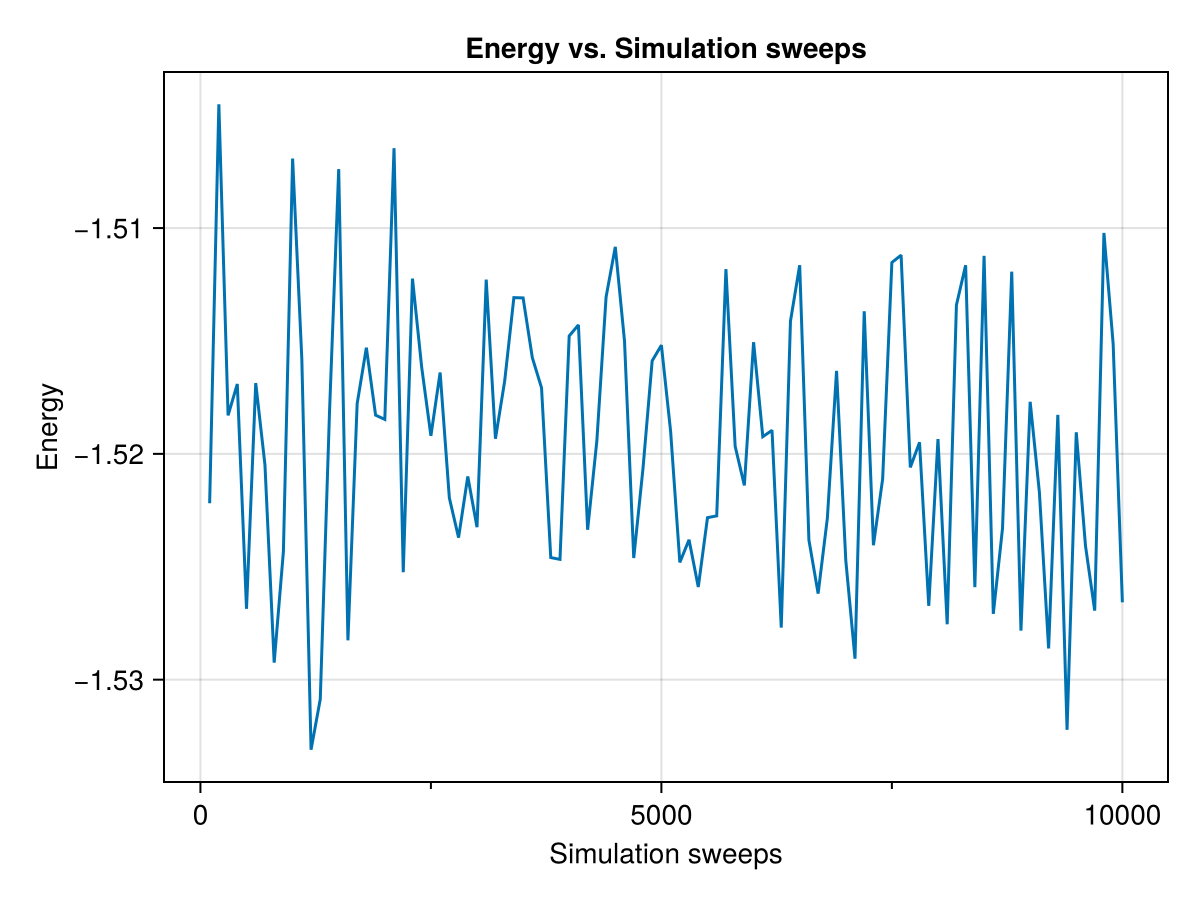

In [17]:
fig = Figure()

ax = fig[1,1] = Axis(
    fig,
    title="Energy vs. Simulation sweeps",
    xlabel="Simulation sweeps",
    ylabel="Energy",
    xminorticksvisible=true
)

task_no = "40"
h5open("../jobs/" * jobname * ".data/task00" * task_no * "/run0001.meas.h5") do file
    mag_group = file["observables/Energy"]
    mag_samples = read(mag_group, "samples")
    bin_len = read(mag_group, "bin_length")
    lines!(
        bin_len .* collect(1:length(mag_samples)),
        mag_samples,
        label="T = 2.2435698905536414"
    )
end

fig

In [18]:
task_no = "42"
file = h5open("../jobs/j1-sweep.data/task00" * task_no * "/run0001.dump.h5")
spins = map(
    t -> [t[:data][1], t[:data][2], t[:data][3]],
    read(file, "simulation/spins")
)
spin_xs = map(v -> v[1], spins)
spin_ys = map(v -> v[2], spins)
spin_zs = map(v -> v[3], spins)
Lx, Ly = size(spins)
close(file)

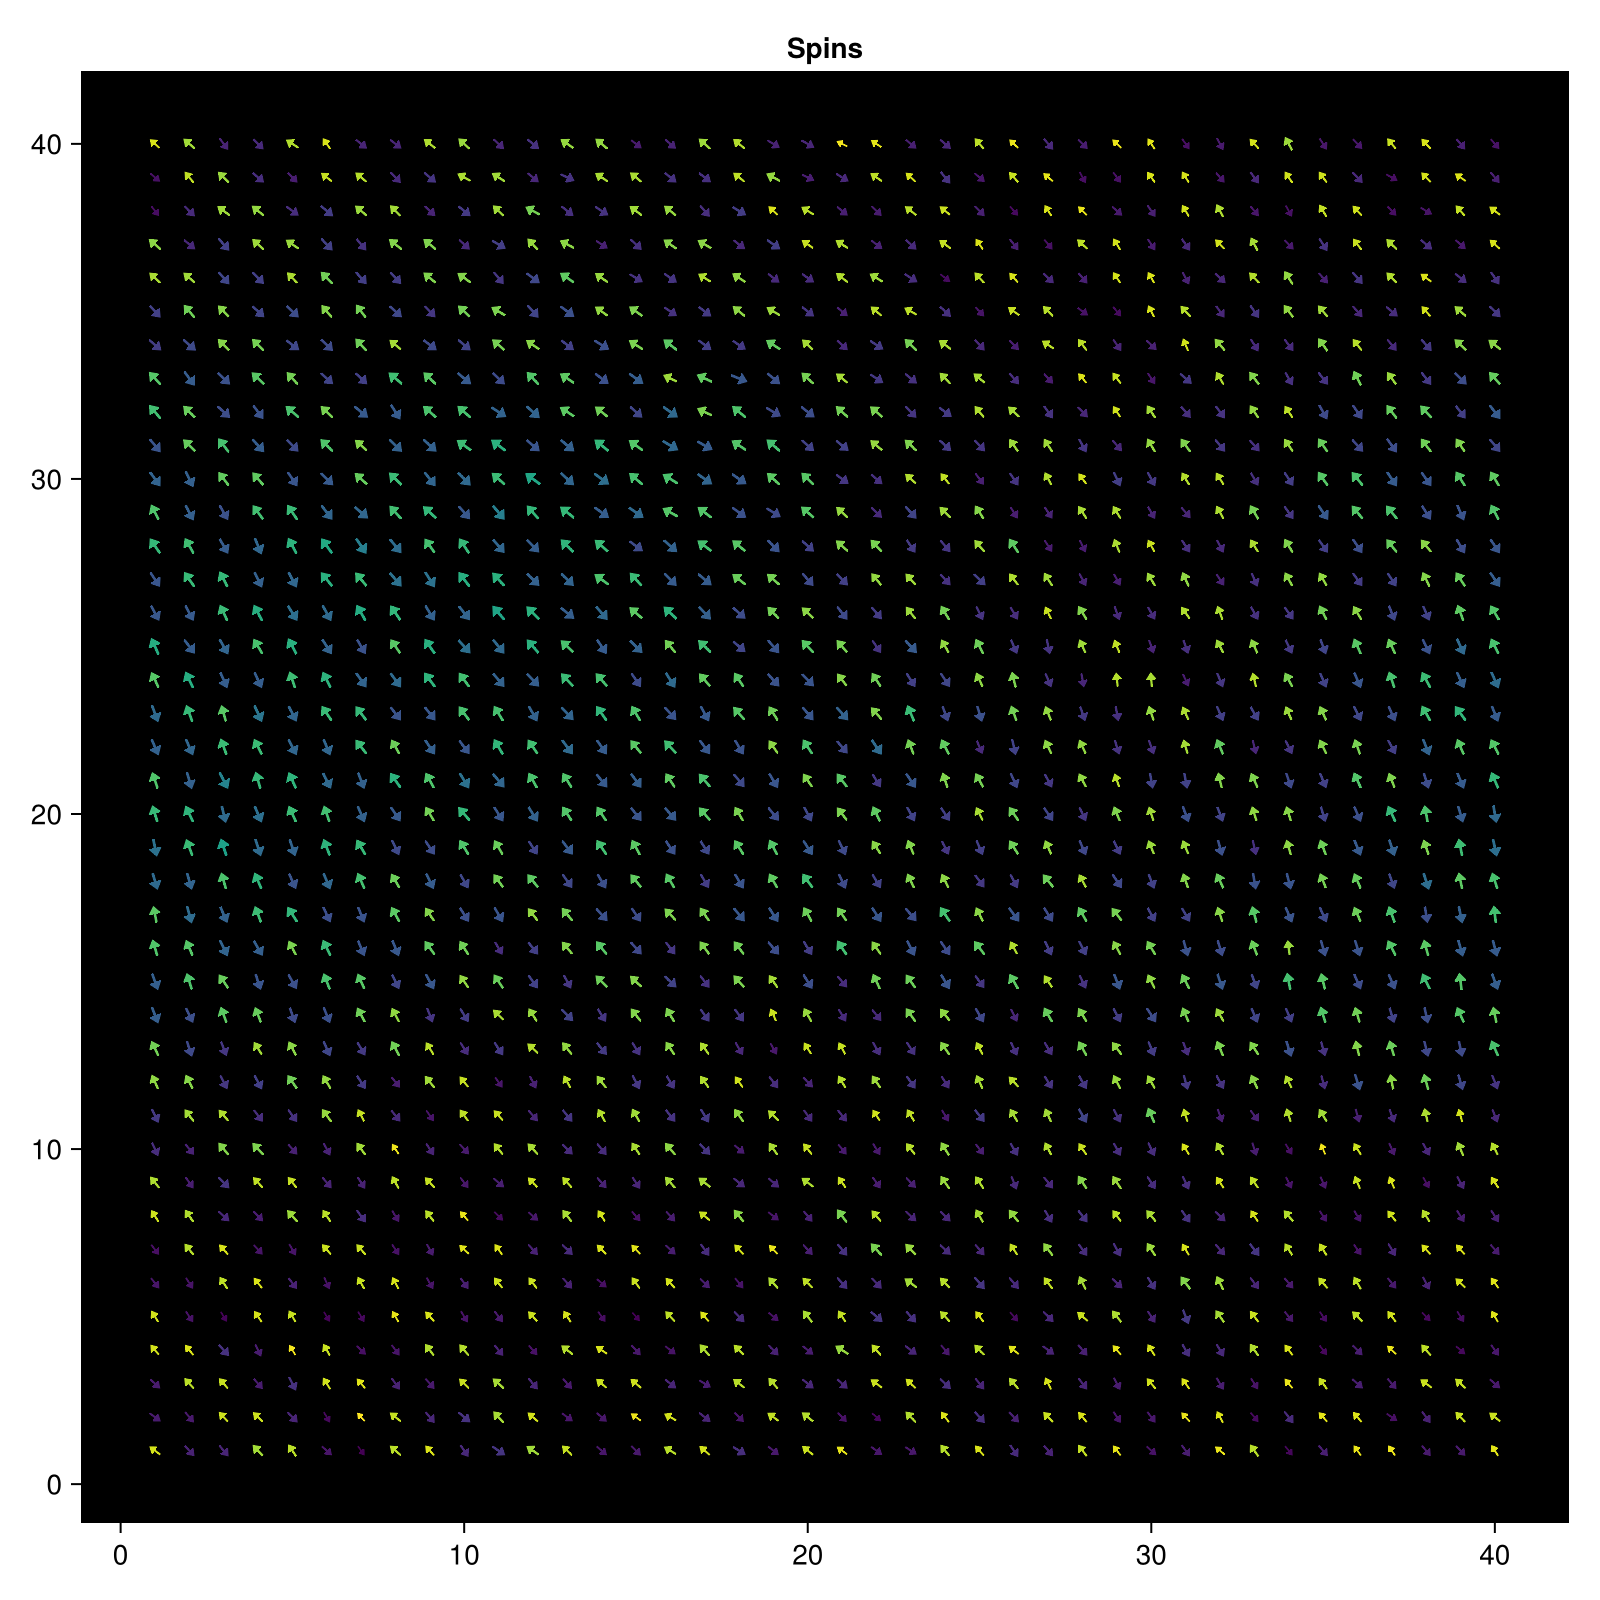

In [19]:
fig = Figure(size=(800, 800))
fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")

strength = vec(spin_zs)
arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength)
fig